In [1]:
import os
import numpy as np
import cv2
import random
import zipfile
from PIL import Image, ImageFilter, ImageFont, ImageDraw
from tqdm import tqdm
from typing import Tuple, List

# ================= 1. CẤU HÌNH =================
# Đảm bảo đường dẫn này đúng trên Kaggle của bạn
FONT_DIR = "/kaggle/input/kanji-fonts1/fonts" 
OUTPUT_DIR = "/kaggle/working"
ZIP_FILENAME = "kanji_dataset_full.zip"
SAMPLES_PER_KANJI = 50 
FONT_SIZE = 64
BATCH_SIZE = 50 # Số lượng chữ xử lý mỗi lần (giảm xuống nếu RAM bị tràn)

# ================= 2. HÀM XỬ LÝ ẢNH =================

def distort_sample(img: Image.Image) -> Image.Image:
    """Hàm làm méo ảnh để tăng cường dữ liệu (Data Augmentation)"""
    t = random.choice(["rotate", "shear", "erode", "dilate", "none"])
    f = random.choice(["blur", "sharpen", "smooth", "none"])

    # Xoay ảnh
    if "rotate" in t:
        img = img.rotate(random.uniform(-10, 10), fillcolor=0)
    
    # Nghiêng ảnh (Shear)
    if "shear" in t:
        y_shear = random.uniform(-0.2, 0.2)
        x_shear = random.uniform(-0.2, 0.2)
        img = img.transform(img.size, Image.AFFINE, (1, x_shear, 0, y_shear, 1, 0), fillcolor=0)

    # Chuyển sang numpy để xử lý OpenCV
    t_img = np.array(img)
    
    # Biến đổi sóng (Sine transform) - Chỉ áp dụng đôi khi
    if random.random() < 0.3 and t_img.shape[0] > 0:
        A = t_img.shape[0] / random.uniform(3.0, 6.0)
        w = 2.0 / t_img.shape[1]
        shift_factor = random.choice([-1, 1]) * random.uniform(0.05, 0.1)
        shift = lambda x: shift_factor * A * np.sin(2 * np.pi * x * w)
        
        for i in range(t_img.shape[0]):
            t_img[:, i] = np.roll(t_img[:, i], int(shift(i)))

    if "erode" in t:
        kernel = np.ones((2, 2), np.uint8)
        t_img = cv2.erode(t_img, kernel, iterations=1)
    if "dilate" in t:
        kernel = np.ones((2, 2), np.uint8)
        t_img = cv2.dilate(t_img, kernel, iterations=1)
    
    img = Image.fromarray(t_img, mode="L")

    # Bộ lọc Pillow
    if "blur" in f:
        img = img.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 1.0)))
    if "sharpen" in f:
        img = img.filter(ImageFilter.SHARPEN)
    if "smooth" in f:
        img = img.filter(ImageFilter.SMOOTH)

    return img

def generate_images(amounts: List[int], kanjis: List[str], fonts_list: List[List[str]], font_size: int = 50) -> Tuple[np.ndarray, np.ndarray]:
    """Hàm sinh ảnh từ font chữ"""
    total_images = sum(amounts)
    kanji_labels = [] # Dùng list rồi convert sang numpy sau cho an toàn
    kanji_imgs = []

    for kanji_cnt, kanji in enumerate(kanjis):
        # 1. Load các font hợp lệ
        ttfs = []
        current_fonts = fonts_list[kanji_cnt]
        
        for f_path in current_fonts:
            try:
                ttfs.append(ImageFont.truetype(f_path, font_size))
            except Exception as e:
                # print(f"Lỗi load font {f_path}: {e}")
                continue
        
        if not ttfs:
            print(f"Cảnh báo: Không load được font nào cho chữ {kanji}")
            # Vẫn tiếp tục để giữ index, nhưng sẽ không có ảnh cho chữ này
            continue

        generated_count = 0
        target_amount = amounts[kanji_cnt]

        # 2. Sinh ảnh gốc từ Font (Không biến dạng)
        # Chúng ta cố gắng dùng mỗi font một lần cho đến khi hết font hoặc đủ số lượng
        for i in range(len(ttfs)):
            if generated_count >= target_amount: break
            
            font = ttfs[i]
            
            # Tính toán kích thước chữ (Fix lỗi Pillow getsize)
            try:
                left, top, right, bottom = font.getbbox(kanji)
                text_w, text_h = right - left, bottom - top
            except:
                # Fallback nếu font không render được chữ này
                continue

            # Scale font nếu chữ quá to so với khung 64x64
            temp_font = font
            max_dim = max(text_w, text_h)
            if max_dim > 54: # Để lề một chút (64 - 10)
                scale_factor = 54 / max_dim
                new_size = int(font_size * scale_factor)
                try:
                    temp_font = font.font_variant(size=new_size)
                    left, top, right, bottom = temp_font.getbbox(kanji)
                    text_w, text_h = right - left, bottom - top
                except:
                    pass

            # Vẽ chữ
            img = Image.new(mode="L", size=(64, 64), color=0) # Nền đen
            d = ImageDraw.Draw(img)
            
            # Căn giữa
            x = (64 - text_w) // 2 - left
            y = (64 - text_h) // 2 - top
            d.text((x, y), kanji, font=temp_font, fill=255) # Chữ trắng

            kanji_imgs.append(np.array(img).reshape(64, 64, 1))
            kanji_labels.append(kanji)
            generated_count += 1
        
        # 3. Sinh ảnh biến dạng (Augmentation) cho đủ số lượng còn thiếu
        # Lấy mẫu từ các ảnh gốc vừa tạo
        base_imgs_for_kanji = kanji_imgs[-generated_count:] if generated_count > 0 else []
        
        if len(base_imgs_for_kanji) == 0:
            print(f"Bỏ qua {kanji} vì không tạo được ảnh gốc nào.")
            continue

        while generated_count < target_amount:
            # Chọn ngẫu nhiên một ảnh gốc để làm méo
            base_arr = random.choice(base_imgs_for_kanji)
            
            # Chuyển về PIL Image
            p_img = Image.fromarray(base_arr.reshape(64, 64))
            
            # Distort
            distorted_img = distort_sample(p_img)
            
            kanji_imgs.append(np.array(distorted_img).reshape(64, 64, 1))
            kanji_labels.append(kanji)
            generated_count += 1
            
    return np.array(kanji_imgs, dtype=np.uint8), np.array(kanji_labels)

# ================= 3. CHẠY CHƯƠNG TRÌNH CHÍNH =================

# Dữ liệu thô (đã cắt bớt để ngắn gọn, hãy paste chuỗi đầy đủ của bạn vào đây)
raw_text = """
一 七 三 上 下 中 九 二 五 人 休 先 入 八 六 円 出 力 十 千 口 右 名 四 土 夕 大 天 女 子 字 学 小 山 川 左 年 手 文 日 早 月 木 本 村 林 校 森 正 気 水 火 犬 玉 王 生 田 男 町 白 百 目 石 空 立 竹 糸 耳 花 草 虫 見 貝 赤 足 車 金 雨 青 音
万 丸 交 京 今 会 体 何 作 元 兄 光 公 内 冬 刀 分 切 前 北 午 半 南 原 友 古 台 合 同 回 図 国 園 地 場 声 売 夏 外 多 夜 太 妹 姉 室 家 寺 少 岩 工 市 帰 広 店 弓 引 弟 弱 強 当 形 後 心 思 戸 才 教 数 新 方 明 星 春 昼 時 晴 曜 書 朝 来 東 楽 歌 止 歩 母 毎 毛 池 汽 活 海 点 父 牛 理 用 画 番 直 矢 知 社 秋 科 答 算 米 紙 細 組 絵 線 羽 考 聞 肉 自 船 色 茶 行 西 親 角 言 計 記 話 語 読 谷 買 走 近 通 週 道 遠 里 野 長 門 間 雪 雲 電 頭 顔 風 食 首 馬 高 魚 鳥 鳴 麦 黄 黒
丁 世 両 主 乗 予 事 仕 他 代 住 使 係 倍 全 具 写 列 助 勉 動 勝 化 区 医 去 反 取 受 号 向 君 味 命 和 品 員 商 問 坂 央 始 委 守 安 定 実 客 宮 宿 寒 対 局 屋 岸 島 州 帳 平 幸 度 庫 庭 式 役 待 急 息 悪 悲 想 意 感 所 打 投 拾 持 指 放 整 旅 族 昔 昭 暑 暗 曲 有 服 期 板 柱 根 植 業 様 横 橋 次 歯 死 氷 決 油 波 注 泳 洋 流 消 深 温 港 湖 湯 漢 炭 物 球 由 申 界 畑 病 発 登 皮 皿 相 県 真 着 短 研 礼 神 祭 福 秒 究 章 童 笛 第 筆 等 箱 級 終 緑 練 羊 美 習 者 育 苦 荷 落 葉 薬 血 表 詩 調 談 豆 負 起 路 身 転 軽 農 返 追 送 速 進 遊 運 部 都 配 酒 重 鉄 銀 開 院 陽 階 集 面 題 飲 館 駅 鼻
不 争 付 令 以 仲 伝 位 低 例 便 信 倉 候 借 停 健 側 働 億 兆 児 共 兵 典 冷 初 別 利 刷 副 功 加 努 労 勇 包 卒 協 単 博 印 参 史 司 各 告 周 唱 喜 器 囲 固 型 堂 塩 士 変 夫 失 好 季 孫 完 官 害 察 巣 差 希 席 帯 底 府 康 建 径 徒 得 必 念 愛 成 戦 折 挙 改 救 敗 散 料 旗 昨 景 最 望 未 末 札 材 束 松 果 栄 案 梅 械 極 標 機 欠 歴 残 殺 毒 氏 民 求 治 法 泣 浅 浴 清 満 漁 灯 無 然 焼 照 熱 牧 特 産 的 省 祝 票 種 積 競 笑 管 節 粉 紀 約 結 給 続 置 老 胃 脈 腸 臣 航 良 芸 芽 英 菜 街 衣 要 覚 観 訓 試 説 課 議 象 貨 貯 費 賞 軍 輪 辞 辺 連 達 選 郡 量 録 鏡 関 陸 隊 静 順 願 類 飛 飯 養 験
久 仏 仮 件 任 似 余 価 保 修 俵 個 備 像 再 刊 判 制 券 則 効 務 勢 厚 句 可 営 因 団 圧 在 均 基 報 境 墓 増 夢 妻 婦 容 寄 富 導 居 属 布 師 常 幹 序 弁 張 往 復 徳 志 応 快 性 恩 情 態 慣 承 技 招 授 採 接 提 損 支 政 故 敵 断 旧 易 暴 条 枝 査 格 桜 検 構 武 比 永 河 液 混 減 測 準 演 潔 災 燃 版 犯 状 独 率 現 留 略 益 眼 破 確 示 祖 禁 移 程 税 築 精 素 経 統 絶 綿 総 編 績 織 罪 群 義 耕 職 肥 能 興 舌 舎 術 衛 製 複 規 解 設 許 証 評 講 謝 識 護 豊 財 貧 責 貸 貿 賀 資 賛 質 輸 述 迷 退 逆 造 過 適 酸 鉱 銅 銭 防 限 険 際 雑 非 預 領 額 飼
並 乱 乳 亡 仁 供 俳 値 傷 優 党 冊 処 刻 割 創 劇 勤 危 卵 厳 収 后 否 吸 呼 善 困 垂 城 域 奏 奮 姿 存 孝 宅 宇 宗 宙 宝 宣 密 寸 専 射 将 尊 就 尺 届 展 層 己 巻 幕 干 幼 庁 座 延 律 従 忘 忠 憲 我 批 担 拝 拡 捨 探 推 揮 操 敬 映 晩 暖 暮 朗 机 枚 染 株 棒 模 権 樹 欲 段 沿 泉 洗 派 済 源 潮 激 灰 熟 片 班 異 疑 痛 皇 盛 盟 看 砂 磁 私 秘 穀 穴 窓 筋 策 簡 糖 系 紅 納 純 絹 縦 縮 署 翌 聖 肺 背 胸 脳 腹 臓 臨 至 若 著 蒸 蔵 蚕 衆 裁 装 裏 補 視 覧 討 訪 訳 詞 誌 認 誕 誠 誤 論 諸 警 貴 賃 遺 郵 郷 針 鋼 閉 閣 降 陛 除 障 難 革 頂 骨
"""
KANJI_LIST = raw_text.split()
print(f"Tổng số Kanji cần sinh: {len(KANJI_LIST)}")

# Lấy danh sách Font
if not os.path.exists(FONT_DIR):
    print(f"Lỗi: Không tìm thấy thư mục font tại {FONT_DIR}")
    # Tạo font ảo để test nếu cần
    # font_paths = [] 
else:
    font_paths = [os.path.join(FONT_DIR, f) for f in os.listdir(FONT_DIR) if f.endswith(('.ttf', '.otf', '.TTC', '.ttc'))]
    print(f"Tìm thấy {len(font_paths)} fonts.")

# Sinh và lưu file Zip
zip_path = os.path.join(OUTPUT_DIR, ZIP_FILENAME)

print(f"Đang sinh dữ liệu và nén vào {zip_path}...")
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zf:
    
    # Chia nhỏ batch để sinh
    for i in tqdm(range(0, len(KANJI_LIST), BATCH_SIZE)):
        batch_kanjis = KANJI_LIST[i : i + BATCH_SIZE]
        batch_amounts = [SAMPLES_PER_KANJI] * len(batch_kanjis)
        batch_fonts = [font_paths] * len(batch_kanjis)
        
        try:
            # Gọi hàm sinh
            imgs, lbls = generate_images(batch_amounts, batch_kanjis, batch_fonts, FONT_SIZE)
            
            if len(imgs) > 0:
                # Lưu tạm thành file .npy
                temp_img_path = "temp_imgs.npy"
                temp_lbl_path = "temp_lbls.npy"
                
                np.save(temp_img_path, imgs)
                np.save(temp_lbl_path, lbls)
                
                # Ghi vào Zip
                zf.write(temp_img_path, f"batch_{i}_imgs.npy")
                zf.write(temp_lbl_path, f"batch_{i}_lbls.npy")
                
                # Xóa file tạm
                if os.path.exists(temp_img_path): os.remove(temp_img_path)
                if os.path.exists(temp_lbl_path): os.remove(temp_lbl_path)
            
        except Exception as e:
            print(f"Lỗi batch {i}: {e}")

print("Hoàn tất!")

Tổng số Kanji cần sinh: 1006
Tìm thấy 7 fonts.
Đang sinh dữ liệu và nén vào /kaggle/working/kanji_dataset_full.zip...


  0%|          | 0/21 [00:00<?, ?it/s]/tmp/ipykernel_47/634138369.py:56: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(t_img, mode="L")
100%|██████████| 21/21 [00:58<00:00,  2.78s/it]

Hoàn tất!


2025-11-29 16:40:29.061142: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764434429.246328      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764434429.309560      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✅ Đã bật chế độ Mixed Precision: mixed_float16
--- Đang giải nén dữ liệu vào RAM ---
Tổng số ảnh: (50300, 64, 64, 1)
--- Đang xử lý nhãn ---
✅ Đã lưu file nhãn. Tổng số Kanji: 1006
Train set: (45270, 64, 64, 1)
Val set:   (5030, 64, 64, 1)


I0000 00:00:1764434446.021763      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764434446.022436      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


--- Đang khởi tạo Model ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- BẮT ĐẦU TRAIN (7 Fonts - 1006 Class) ---
Epoch 1/20


I0000 00:00:1764434487.624587     119 service.cc:148] XLA service 0x7945e0002220 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764434487.625372     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764434487.625390     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764434493.765416     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/354 ━━━━━━━━━━━━━━━━━━━━ 8:54:50 91s/step - accuracy: 0.0000e+00 - loss: 8.0304

I0000 00:00:1764434539.839236     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.0021 - loss: 7.7502
Epoch 1: val_accuracy improved from -inf to 0.00139, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 170s 224ms/step - accuracy: 0.0021 - loss: 7.7493 - val_accuracy: 0.0014 - val_loss: 7.2790 - learning_rate: 1.0000e-04
Epoch 2/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0481 - loss: 6.0723
Epoch 2: val_accuracy improved from 0.00139 to 0.02147, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.0482 - loss: 6.0708 - val_accuracy: 0.0215 - val_loss: 6.3760 - learning_rate: 1.0000e-04
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2812 - loss: 3.8495
Epoch 3: val_accuracy improved from 0.02147 to 0.39384, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.2815 - loss: 3.8480 - val_accuracy: 0.3938 - val_loss: 3.2840 - learning_rate: 1.0000e-04
Epoch 4/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6154 - loss: 1.9633
Epoch 4: val_accuracy improved from 0.39384 to 0.73400, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.6156 - loss: 1.9624 - val_accuracy: 0.7340 - val_loss: 1.5169 - learning_rate: 1.0000e-04
Epoch 5/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8131 - loss: 0.9694
Epoch 5: val_accuracy improved from 0.73400 to 0.81213, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8132 - loss: 0.9686 - val_accuracy: 0.8121 - val_loss: 1.0388 - learning_rate: 1.0000e-04
Epoch 6/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9006 - loss: 0.5257
Epoch 6: val_accuracy did not improve from 0.81213
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9007 - loss: 0.5254 - val_accuracy: 0.8032 - val_loss: 1.0059 - learning_rate: 1.0000e-04
Epoch 7/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9422 - loss: 0.3228
Epoch 7: val_accuracy improved from 0.81213 to 0.91074, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9422 - loss: 0.3226 - val_accuracy: 0.9107 - val_loss: 0.4606 - learning_rate: 1.0000e-04
Epoch 8/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9638 - loss: 0.2062
Epoch 8: val_accuracy improved from 0.91074 to 0.97753, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9638 - loss: 0.2061 - val_accuracy: 0.9775 - val_loss: 0.1358 - learning_rate: 1.0000e-04
Epoch 9/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9772 - loss: 0.1424
Epoch 9: val_accuracy improved from 0.97753 to 0.98350, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.9772 - loss: 0.1423 - val_accuracy: 0.9835 - val_loss: 0.0953 - learning_rate: 1.0000e-04
Epoch 10/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9844 - loss: 0.1015
Epoch 10: val_accuracy did not improve from 0.98350
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9844 - loss: 0.1015 - val_accuracy: 0.9577 - val_loss: 0.1992 - learning_rate: 1.0000e-04
Epoch 11/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9879 - loss: 0.0798
Epoch 11: val_accuracy did not improve from 0.98350
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9879 - loss: 0.0797 - val_accuracy: 0.9813 - val_loss: 0.0862 - learning_rate: 1.0000e-04
Epoch 12/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9922 - loss: 0.0559
Epoch 12: val_accuracy improved from 0.98350 to 0.98807, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9922 - loss: 0.0558 - val_accuracy: 0.9881 - val_loss: 0.0601 - learning_rate: 1.0000e-04
Epoch 13/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9936 - loss: 0.0455
Epoch 13: val_accuracy improved from 0.98807 to 0.98887, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9936 - loss: 0.0455 - val_accuracy: 0.9889 - val_loss: 0.0482 - learning_rate: 1.0000e-04
Epoch 14/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9947 - loss: 0.0372
Epoch 14: val_accuracy did not improve from 0.98887
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9947 - loss: 0.0371 - val_accuracy: 0.9746 - val_loss: 0.1069 - learning_rate: 1.0000e-04
Epoch 15/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9961 - loss: 0.0298
Epoch 15: val_accuracy improved from 0.98887 to 0.99145, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9961 - loss: 0.0298 - val_accuracy: 0.9915 - val_loss: 0.0328 - learning_rate: 1.0000e-04
Epoch 16/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9977 - loss: 0.0214
Epoch 16: val_accuracy improved from 0.99145 to 0.99284, saving model to /kaggle/working/best_efficientnet_kanji.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9977 - loss: 0.0214 - val_accuracy: 0.9928 - val_loss: 0.0312 - learning_rate: 1.0000e-04
Epoch 17/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9970 - loss: 0.0208
Epoch 17: val_accuracy did not improve from 0.99284
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9970 - loss: 0.0208 - val_accuracy: 0.9897 - val_loss: 0.0487 - learning_rate: 1.0000e-04
Epoch 18/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9975 - loss: 0.0180
Epoch 18: val_accuracy did not improve from 0.99284
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9975 - loss: 0.0180 - val_accuracy: 0.9911 - val_loss: 0.0397 - learning_rate: 1.0000e-04
Epoch 19/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9970 - loss: 0.0173
Epoch 19: val_accuracy did not improve from 0.99284
354/354 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9970 - loss: 0.0173 - val_accuracy: 0.9732 - val_loss: 0.1101 - learning_rate: 1.0

354/354 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.9986 - loss: 0.0126 - val_accuracy: 0.9944 - val_loss: 0.0185 - learning_rate: 2.0000e-05
--- HOÀN TẤT TRAIN! ---


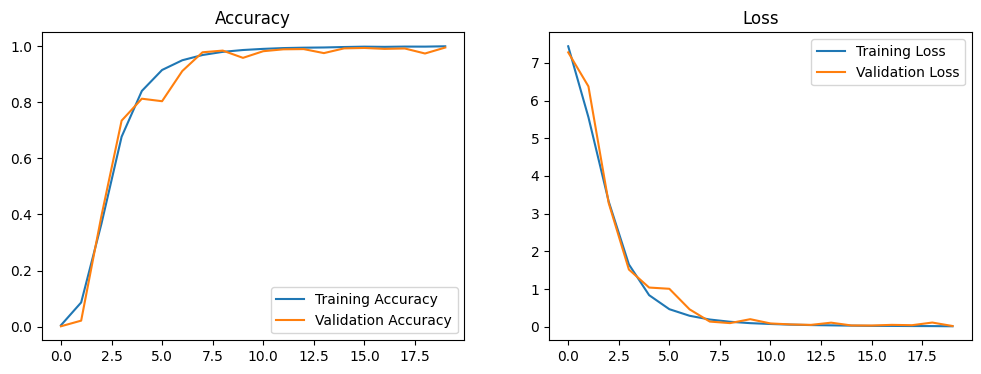

In [2]:
import os
import zipfile
import numpy as np
import pickle
import gc 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt

# ================= 0. CẤU HÌNH TĂNG TỐC =================
try:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print(f"✅ Đã bật chế độ Mixed Precision: {policy.name}")
except:
    print("⚠️ Không thể bật Mixed Precision")

# ================= 1. CẤU HÌNH CHUNG =================
ZIP_PATH = "/kaggle/working/kanji_dataset_full.zip"
IMG_SIZE = 64
BATCH_SIZE = 128 
EPOCHS = 20      

# ================= 2. LOAD DỮ LIỆU TỪ ZIP =================
print("--- Đang giải nén dữ liệu vào RAM ---")

all_imgs = []
all_lbls = []

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    file_list = zf.namelist()
    img_files = sorted([f for f in file_list if f.endswith('_imgs.npy')])
    lbl_files = sorted([f for f in file_list if f.endswith('_lbls.npy')])
    
    for img_f, lbl_f in zip(img_files, lbl_files):
        with zf.open(img_f) as f:
            imgs = np.load(f)
            all_imgs.append(imgs)
        with zf.open(lbl_f) as f:
            lbls = np.load(f)
            all_lbls.append(lbls)

X_data = np.concatenate(all_imgs, axis=0)
y_data_raw = np.concatenate(all_lbls, axis=0)

del all_imgs, all_lbls
gc.collect()

print(f"Tổng số ảnh: {X_data.shape}")

# ================= 3. XỬ LÝ DỮ LIỆU =================
print("--- Đang xử lý nhãn ---")

le = LabelEncoder()
y_integers = le.fit_transform(y_data_raw)
num_classes = len(le.classes_)

# Lưu map nhãn mới (Quan trọng: Map này phải khớp với model mới)
labels_map = dict(zip(le.transform(le.classes_), le.classes_))
with open("/kaggle/working/kanji_labels_map.pkl", "wb") as f:
    pickle.dump(labels_map, f)
print(f"✅ Đã lưu file nhãn. Tổng số Kanji: {num_classes}")

del y_data_raw
gc.collect()

# Chia tập Train/Val
X_train, X_val, y_train, y_val = train_test_split(X_data, y_integers, test_size=0.1, random_state=42, stratify=y_integers)

del X_data, y_integers
gc.collect()

print(f"Train set: {X_train.shape}")
print(f"Val set:   {X_val.shape}")

# Tạo Dataset Pipeline
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.grayscale_to_rgb(image) 
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(5000).map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ================= 4. XÂY DỰNG MODEL =================
print("--- Đang khởi tạo Model ---")

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True # Cho phép học lại toàn bộ

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(), # Giúp hội tụ ổn định
    layers.Dropout(0.5),         # Tăng cường chống học vẹt
    layers.Dense(num_classes, activation='softmax', dtype='float32')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# ================= 5. HUẤN LUYỆN =================
print(f"--- BẮT ĐẦU TRAIN (7 Fonts - {num_classes} Class) ---")

checkpoint = callbacks.ModelCheckpoint("/kaggle/working/best_efficientnet_kanji.h5", 
                                       monitor='val_accuracy', 
                                       save_best_only=True, 
                                       mode='max', verbose=1)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("--- HOÀN TẤT TRAIN! ---")

# Vẽ biểu đồ
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.savefig("/kaggle/working/training_result.png")
plt.show()

--- Đang giải nén dữ liệu ---
Số lớp: 1006
--- Đang khởi tạo Simple CNN ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1006)           │       258,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,302 (2.47 MB)

 Trainable params: 647,342 (2.47 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0208 - loss: 6.5843
Epoch 1: val_accuracy improved from -inf to 0.00179, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - accuracy: 0.0210 - loss: 6.5817 - val_accuracy: 0.0018 - val_loss: 8.0490 - learning_rate: 0.0010
Epoch 2/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5214 - loss: 2.6315
Epoch 2: val_accuracy improved from 0.00179 to 0.88907, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5240 - loss: 2.6186 - val_accuracy: 0.8891 - val_loss: 1.0726 - learning_rate: 0.0010
Epoch 3/20
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9112 - loss: 0.6107
Epoch 3: val_accuracy improved from 0.88907 to 0.98668, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9113 - loss: 0.6103 - val_accuracy: 0.9867 - val_loss: 0.1999 - learning_rate: 0.0010
Epoch 4/20
350/354 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9715 - loss: 0.2364
Epoch 4: val_accuracy improved from 0.98668 to 0.99463, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9716 - loss: 0.2359 - val_accuracy: 0.9946 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 5/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9873 - loss: 0.1252
Epoch 5: val_accuracy improved from 0.99463 to 0.99642, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9873 - loss: 0.1250 - val_accuracy: 0.9964 - val_loss: 0.0706 - learning_rate: 0.0010
Epoch 6/20
351/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9915 - loss: 0.0783
Epoch 6: val_accuracy improved from 0.99642 to 0.99682, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9915 - loss: 0.0783 - val_accuracy: 0.9968 - val_loss: 0.0456 - learning_rate: 0.0010
Epoch 7/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9937 - loss: 0.0529
Epoch 7: val_accuracy did not improve from 0.99682
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9938 - loss: 0.0528 - val_accuracy: 0.9964 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 8/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9965 - loss: 0.0402
Epoch 8: val_accuracy improved from 0.99682 to 0.99801, saving model to /kaggle/working/best_simple_cnn.h5


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9965 - loss: 0.0402 - val_accuracy: 0.9980 - val_loss: 0.0250 - learning_rate: 0.0010
Epoch 9/20
350/354 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9976 - loss: 0.0305
Epoch 9: val_accuracy did not improve from 0.99801
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9976 - loss: 0.0305 - val_accuracy: 0.9970 - val_loss: 0.0206 - learning_rate: 0.0010
Epoch 10/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9968 - loss: 0.0291
Epoch 10: val_accuracy did not improve from 0.99801
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9968 - loss: 0.0291 - val_accuracy: 0.9974 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 11/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0223
Epoch 11: val_accuracy did not improve from 0.99801
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9980 - loss: 0.0223 - val_accuracy: 0.9978 - val_loss: 0.0149 - learning_rate: 0.0010
Epoch 12/20
353/

354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9985 - loss: 0.0145 - val_accuracy: 0.9998 - val_loss: 0.0041 - learning_rate: 5.0000e-04
Epoch 15/20
352/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9993 - loss: 0.0082
Epoch 15: val_accuracy did not improve from 0.99980
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9993 - loss: 0.0082 - val_accuracy: 0.9996 - val_loss: 0.0053 - learning_rate: 5.0000e-04
Epoch 16/20
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9995 - loss: 0.0066
Epoch 16: val_accuracy did not improve from 0.99980
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9995 - loss: 0.0066 - val_accuracy: 0.9998 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 17/20
353/354 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9994 - loss: 0.0062
Epoch 17: val_accuracy did not improve from 0.99980
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9994 - loss: 0.0062 - val_accuracy: 0.9996 - val_loss: 0.0044 - learning_rate: 5.0000e-04

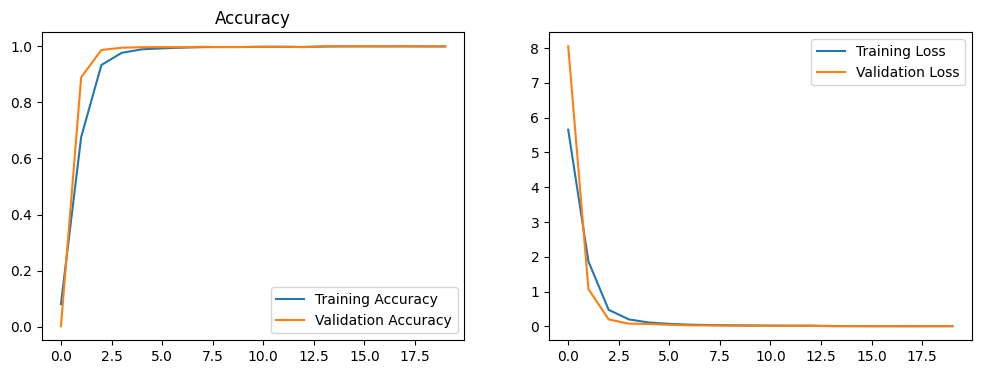

In [3]:
import os
import zipfile
import numpy as np
import pickle
import gc 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# ================= 1. CẤU HÌNH =================
ZIP_PATH = "/kaggle/working/kanji_dataset_full.zip"
IMG_SIZE = 64
BATCH_SIZE = 128
EPOCHS = 20

# ================= 2. LOAD DỮ LIỆU =================
print("--- Đang giải nén dữ liệu ---")
all_imgs = []
all_lbls = []

with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    file_list = zf.namelist()
    img_files = sorted([f for f in file_list if f.endswith('_imgs.npy')])
    lbl_files = sorted([f for f in file_list if f.endswith('_lbls.npy')])
    
    for img_f, lbl_f in zip(img_files, lbl_files):
        with zf.open(img_f) as f:
            imgs = np.load(f)
            all_imgs.append(imgs)
        with zf.open(lbl_f) as f:
            lbls = np.load(f)
            all_lbls.append(lbls)

X_data = np.concatenate(all_imgs, axis=0)
y_data_raw = np.concatenate(all_lbls, axis=0)

del all_imgs, all_lbls
gc.collect()

# ================= 3. XỬ LÝ NHÃN =================
le = LabelEncoder()
y_integers = le.fit_transform(y_data_raw)
num_classes = len(le.classes_)

# Lưu map nhãn (Dùng chung cho cả 2 model)
labels_map = dict(zip(le.transform(le.classes_), le.classes_))
with open("/kaggle/working/kanji_labels_map.pkl", "wb") as f:
    pickle.dump(labels_map, f)
print(f"Số lớp: {num_classes}")

del y_data_raw
gc.collect()

# Chia tập Train/Val
X_train, X_val, y_train, y_val = train_test_split(X_data, y_integers, test_size=0.1, random_state=42, stratify=y_integers)
del X_data, y_integers
gc.collect()

# ================= 4. TẠO DATASET (1 KÊNH MÀU) =================
# Simple CNN chỉ cần 1 kênh màu (Grayscale) -> Nhẹ hơn
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # Không cần convert sang RGB như EfficientNet
    return image, label

AUTOTUNE = tf.data.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(5000).map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# ================= 5. THIẾT KẾ MODEL SIMPLE CNN =================
print("--- Đang khởi tạo Simple CNN ---")

model = models.Sequential([
    # Input: 64x64x1 (Đen trắng)
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    # Block 1
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Block 4
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    # Classifier
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# ================= 6. HUẤN LUYỆN =================
checkpoint = callbacks.ModelCheckpoint("/kaggle/working/best_simple_cnn.h5", 
                                       monitor='val_accuracy', 
                                       save_best_only=True, 
                                       mode='max', verbose=1)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

# Vẽ biểu đồ
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.savefig("/kaggle/working/cnn_result.png")